Mona Mokart

# **TP IMA204 Segementation**





In [1]:
import glob
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from skimage.measure import find_contours
from scipy.spatial.distance import dice
from skimage.transform import rescale
from scipy.io import loadmat

from scipy import ndimage as ndi
from skimage import io as skio
from skimage.filters import threshold_otsu
import skimage.morphology as morpho  
from skimage.transform import rescale
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage import img_as_float
from skimage.segmentation import chan_vese
from skimage.segmentation import checkerboard_level_set
from skimage.segmentation import circle_level_set


--- French ---
L'objectif de ce TP est de tester différentes méthodes de segmentation vues dans les cours sur des images médicales de différents types : scanner à rayons X (CT) pour la segmentation des reins, IRM du cerveau pour la segmentation du corps calleux, séquences temporelles d'images IRM pour la segmentation du coeur (ventricule gauche par exemple), images dermoscopiques de lésions de la peau.
Pour chaque méthode, il faudra la tester et l'évaluer sur le plus possible d'images.



In [2]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd

  gdd.download_file_from_google_drive(file_id='1E-F5x83qaPRUrcdusfyOSgiZWf0pLDFl',
                                      dest_path='./abdominalCT.zip',
                                      unzip=True)

  gdd.download_file_from_google_drive(file_id='1UTSW2nGWV8SBE_ILZQkM-jQvnfoQKDlm',
                                      dest_path='./brainMRI.zip',
                                      unzip=True)  

  gdd.download_file_from_google_drive(file_id='1BZtShVk7LVG032GOlcLs0K4Eaj6gnBed',
                                      dest_path='./MRIheart.zip',
                                      unzip=True)    

  gdd.download_file_from_google_drive(file_id='1BoU4S9xFgKaCtquU03kZQbH3Yv42oU_-',
                                      dest_path='./skinlesion.zip',
                                      unzip=True)   
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
# You should write the absolute path of your working directory with the data
Working_directory="./"                              

Unzipping...Done.
Unzipping...Done.
Unzipping...Done.
Unzipping...Done.


## Abdominal CT 

You have at your disposal 6 abdominal CT scans of different subjects. Subjects may have renal tumor. You also have the manual segmentations for both kidney and, when present, the tumor.

In [ ]:
abdominalCT_path = Working_directory + 'abdominalCT'
!ls './abdominalCT'

listImagesabdCT=glob.glob(abdominalCT_path + '/*-seg.tiff')
print('There are', len(listImagesabdCT),  'abdomical CT images')
print(listImagesabdCT)

CTs1-seg.tiff  CTs2.tiff      CTs4-seg.tiff  CTs5.tiff
CTs1.tiff      CTs3-seg.tiff  CTs4.tiff      CTs6-seg.tiff
CTs2-seg.tiff  CTs3.tiff      CTs5-seg.tiff  CTs6.tiff
There are 6 abdomical CT images
['./abdominalCT/CTs2-seg.tiff', './abdominalCT/CTs5-seg.tiff', './abdominalCT/CTs4-seg.tiff', './abdominalCT/CTs6-seg.tiff', './abdominalCT/CTs3-seg.tiff', './abdominalCT/CTs1-seg.tiff']


Reading image  ./abdominalCT/CTs6.tiff
[  0 127 255]


Text(0.5, 1.0, 'Image with mask tumor')

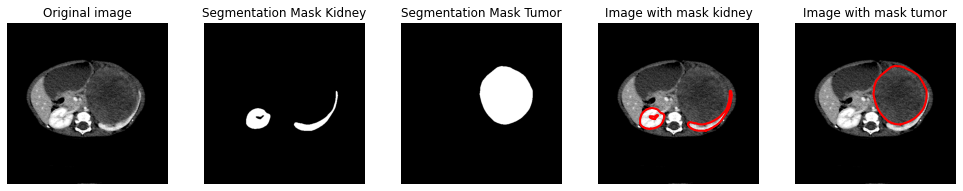

In [ ]:
# Choose a figure and plot it with the ground truth segmentation
indexIm=3
 # between 0 and 5

# Abdominal CT
filename_Segmentation = listImagesabdCT[indexIm]
im_Seg = imread(filename_Segmentation)
filename = filename_Segmentation[:-9] + '.tiff'
imG = imread(filename) 

print('Reading image ', filename)
print(np.unique(im_Seg))

if imG.shape != im_Seg.shape:
  raise NameError('image and mask should have the same shape, problem...')  

# In Im Seg, we may have two values: 127 is for kidney and 255 for renal tumor
maskKidney=im_Seg==127
if np.sum(maskKidney)==0:
  print('There is no kidney')
contourMaskKidney = find_contours(maskKidney, 0.5)

maskTumor=im_Seg==255
if np.sum(maskTumor)==0:
  print('There is no tumor')
contourMaskTumor = find_contours(maskTumor, 0.5)

fig = plt.figure(figsize=(17, 7))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 5),
                axes_pad = 0.5)
grid[0].imshow(imG, cmap='gray')
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(maskKidney,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Segmentation Mask Kidney")
grid[2].imshow(maskTumor,cmap='gray')
grid[2].axis('off')
grid[2].set_title("Segmentation Mask Tumor")
grid[3].imshow(imG, cmap='gray')
for contour in contourMaskKidney:
  grid[3].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[3].axis('off')
grid[3].set_title("Image with mask kidney")
grid[4].imshow(imG, cmap='gray')
for contour in contourMaskTumor:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[4].axis('off')
grid[4].set_title("Image with mask tumor")


**Première approche:**

Test avec Otsu : ici je pense que Otsu ne va pas fonctionner car dans le scan on doit récuperer trois données : la tumeur, le rein et le reste. On peut tester avec Otsu avec deux seuils




In [ ]:
def histogram(im):
    nl,nc=im.shape
    hist=np.zeros(256)
    
    for i in range(nl):
        for j in range(nc):
            hist[im[i][j]]=hist[im[i][j]]+1
            
    for i in range(256):
        hist[i]=hist[i]/(nc*nl)
        
    return(hist)

def otsu_thresh2(im):
    h=histogram(im)
    m=0
    for i in range(256):
        m=m+i*h[i]
    maxt=0
    maxk=0
    
    for t in range(256):
      for t2 in range(t,256):
        w0=0
        w1=0
        w2=0
        m0=0
        m1=0
        m2=0
        for i in range(t):
            w0=w0+h[i]
            m0=m0+i*h[i]
        if w0 > 0:
            m0=m0/w0

        for i in range(t,t2):
          w2=w2+h[i]
          m2=m2+i*h[i]
        if w2 > 0:   
            m2=m2/w2

        for i in range(t2,256):
            w1=w1+h[i]
            m1=m1+i*h[i]
        if w1 > 0:   
            m1=m1/w1
        
        k=w0*w1*(m0-m1)*(m0-m1)   + w2*w1*(m2-m1)*(m2-m1)  + w0*w2*(m0-m2)*(m0-m2)  
        
        if k > maxk:
            maxk=k
            maxt=[t,t2]
    thresh=maxt
        
    return(thresh)

(t1,t2)=otsu_thresh2(imG)
im2 = imG.copy()
for i in range(imG.shape[0]):
  for j in range(imG.shape[1]):
    if imG[i][j]<t1:
      im2[i][j] = 0
    elif  imG[i][j]<t2:
      im2[i][j] = 128
    else :
      im2[i][j] = 255



(-0.5, 511.5, 511.5, -0.5)

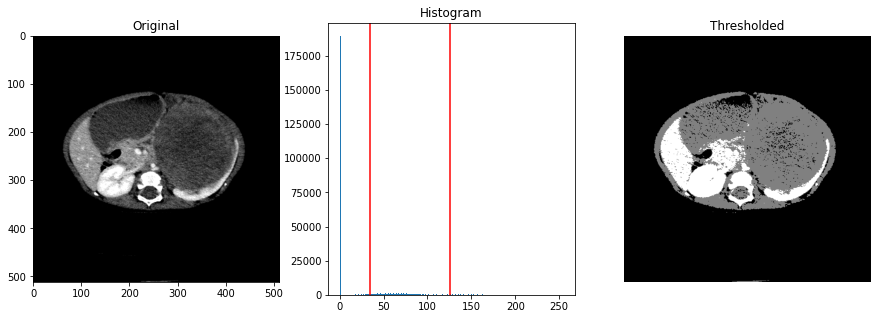

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
ax = axes.ravel()
ax[0].imshow(imG, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].hist(imG.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(t1, color='r')
ax[1].axvline(t2, color='r')

ax[2].imshow(im2, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

Cette technique ne fonctionne pas, l'algorithme a bien séparé en trois classes mais cela ne correspond pas à ce qu'on voulait. Avec k-means à trois classes cela donnerait un resultat similaire. Il faudrait traiter l'iamge d'une autre façon. On peut tester avec k-means mais pour davantage de cluster. De plus je vais faire la segmentation en deux temps : d'abord les reins puis la tumeur.

**K-means avec 4 clusters pour les reins**

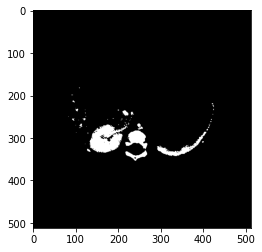

In [ ]:
from sklearn.cluster import KMeans
#Etape 1 : K-means
im=imG
Ncluster=4

x, y = im.shape
imFloat = np.array(im, dtype=np.float64) / 255 # transform into float for computational reason
kmeans = KMeans(n_clusters=Ncluster, n_jobs=-1) # use K-means algorithm 
kmeans.fit(imFloat.reshape(x*y,1)) # fit to the data reshapds as a 1D vector

cluster_centers = kmeans.cluster_centers_ # estimated centers
cluster_labels = kmeans.labels_ # estimated labels for each pixel

kmeansSeg = cluster_centers[cluster_labels].reshape(x, y) # reshaped as the original image
cluster_centers[:,0].sort()
kmeans2=kmeansSeg==cluster_centers[-1]

plt.imshow(kmeans2,cmap="gray")

Décomposition en composantes connexes

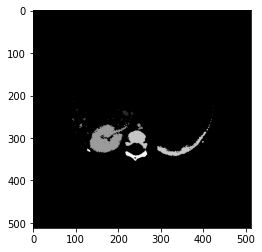

In [ ]:
kmeans3 = ndi.label(kmeans2)[0]
plt.imshow(kmeans3,cmap="gray")

[ 0 40 45 56 57 58 59 60 61 62 63 64 65 66 67 68 69]


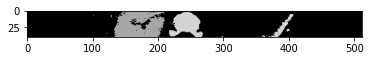

In [ ]:
plt.imshow(kmeans3[280:320,:],cmap="gray")
print(np.unique(kmeans3[280:320,:]))

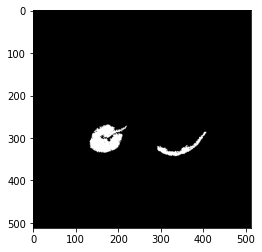

In [ ]:
kmeans4 = (kmeans3==58)+(kmeans3==45)
plt.imshow(kmeans4,cmap="gray")

The dice similarity is  0.8078099694079539


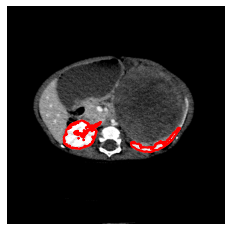

In [ ]:
contourMask = find_contours(kmeans4, 0.5)
plt.imshow(im, cmap='gray')
for contour in contourMask:
  plt.plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
plt.axis('off')
print('The dice similarity is ', 1-dice(kmeans4.flatten(),maskKidney.flatten()))


On a une bonne similarité, j'ai essayé de l'améliorer avec des applications de morphologie mais cela ne change pas vraiment l'erreur. Finalement en appliquant kmeans puis décomposition en composantes connexes on arrive à un bon résultat. Cependant il a fallut que je selectionne moi même, manuellement les bonnes composantes connexes et cette technique ne marcherait pas sur les autres images si on ne changeait pas les paramètres de code.

**Region growing pour la tumeur** 

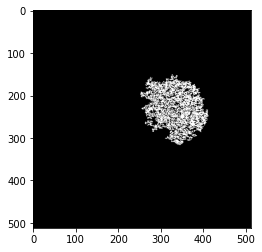

In [ ]:
seed_pt = np.asarray([250,350])  # initialization with only one point - Try to modify the code to initialize with one region obtained previously
tau = 14
img_out_region_growing,seg_init = segmentation_region_growing(im,seed_pt,tau)
plt.imshow(img_out_region_growing,cmap="gray")

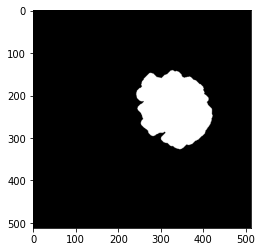

In [ ]:
se = strel('diamond',10)
im_morpho=morpho.closing(img_out_region_growing,se)
im_morpho=morpho.dilation(im_morpho,strel('diamond',5))
im_morpho=morpho.dilation(im_morpho,strel('disk',5))

contourMask = find_contours(im_morpho, 0.5)
plt.imshow(im_morpho,cmap="gray")

The dice similarity is  0.9282365668950595


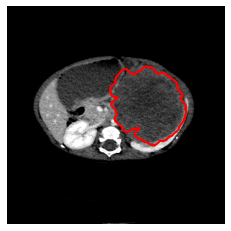

In [ ]:
plt.imshow(im, cmap='gray')
for contour in contourMask:
  plt.plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
plt.axis('off')
print('The dice similarity is ', 1-dice(im_morpho.flatten(),maskTumor.flatten()))

Finalement les résultats ne sont pas mauvais selon la dice-similarity cependant on peut voir qualitativement que ce n'est pas satisfaisant. En effet on a perdu un bout de rein à droite (rein gauche si les scanners sont symétriques) et le masque de segmentation de la tumeur n'est pas lisse. K-means avec la tumeur donnait des résultats qui demandaient encore beaucoup de traitement donc region growing reste raisonnable. 
Pour les prochains cas à traiter ce sera plus facile à trouver un code qui se généralise pour la collection d'image car ce sont des images similaires. Ici c'est impossible avec les outils qu'on a car il y a des images avec un seul rein, sans tumeur, avec des tumeurs de tailles différentes et placées à des zones différentes.

# Brain MRI

Here you can select medial slices of the brain of 4 different subjects. You also have manual segmentations of the corpus callosum.

In [ ]:
brainMRI_path = Working_directory + 'brainMRI'
!ls './brainMRI'

listImagesbrainMRI=glob.glob(brainMRI_path + '/*-seg.png')
print('There are', len(listImagesbrainMRI),  'brain MRI images')
print(listImagesbrainMRI)

MRIs1.png      MRIs2.png      MRIs3.png      MRIs4.png
MRIs1-seg.png  MRIs2-seg.png  MRIs3-seg.png  MRIs4-seg.png
There are 4 brain MRI images
['./brainMRI/MRIs2-seg.png', './brainMRI/MRIs1-seg.png', './brainMRI/MRIs3-seg.png', './brainMRI/MRIs4-seg.png']


./brainMRI/MRIs1-seg.png
Reading image  ./brainMRI/MRIs1.png


Text(0.5, 1.0, 'Image with segmentation\n corpus callosum')

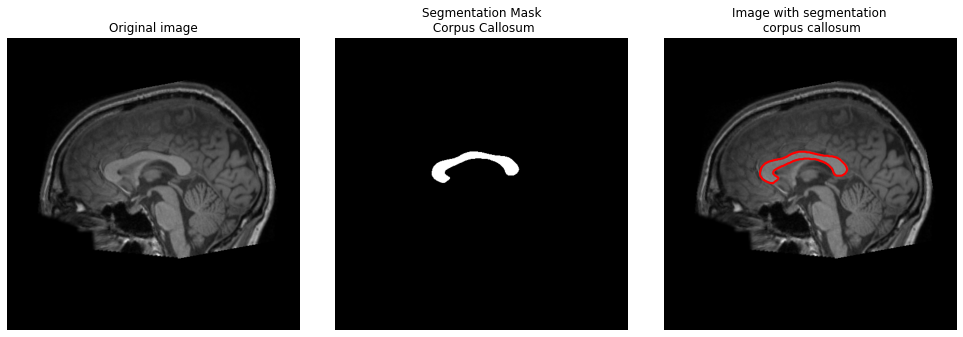

In [ ]:
# Choose a figure and plot it with the ground truth segmentation
indexIm=1 # between 0 and 3
# Brain MRI
filename_Segmentation = listImagesbrainMRI[indexIm]
print(filename_Segmentation)
im_Seg = imread(filename_Segmentation)
filename = filename_Segmentation[:-8] + '.png'
imG = imread(filename) 

#ind=np.unravel_index(np.argsort(im, axis=None), im.shape) #unravel donne les index 2D a partir des index 1d renvoyes par argsort (axis=None)
#imG=np.zeros(im.shape,im.dtype)
#imG[ind]=np.sort(im0,axis=None)

print('Reading image ', filename)

if imG.shape != im_Seg.shape:
  raise NameError('image and mask should have the same shape, problem...')  

# In Im Seg we have masks of the corpus callosum
maskCC=im_Seg==255
contourMask = find_contours(maskCC, 0.5)

fig = plt.figure(figsize=(17, 7))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(imG, cmap='gray')
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(maskCC,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Segmentation Mask\n Corpus Callosum")
grid[2].imshow(imG, cmap='gray')
for contour in contourMask:
  grid[2].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[2].axis('off')
grid[2].set_title("Image with segmentation\n corpus callosum")


**Approche : clustering + decomposition en composante connex + morphologie**

The dice similarity is  0.9179141306135877


<Figure size 1224x504 with 0 Axes>

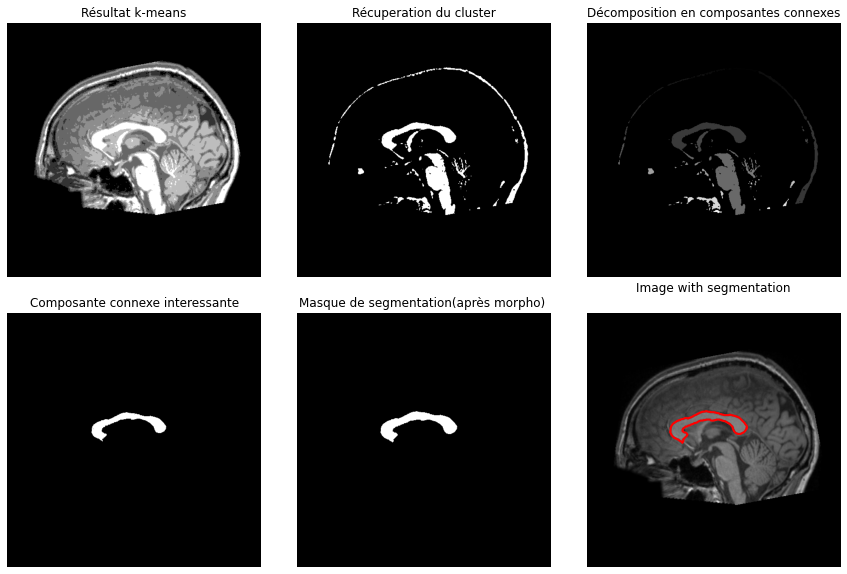

In [ ]:
from sklearn.cluster import KMeans
#Etape 1 : K-means
im=imG
Ncluster=6

x, y = im.shape
imFloat = np.array(im, dtype=np.float64) / 255 # transform into float for computational reason
kmeans = KMeans(n_clusters=Ncluster, n_jobs=-1) # use K-means algorithm 
kmeans.fit(imFloat.reshape(x*y,1)) # fit to the data reshapds as a 1D vector

cluster_centers = kmeans.cluster_centers_ # estimated centers
cluster_labels = kmeans.labels_ # estimated labels for each pixel

kmeansSeg = cluster_centers[cluster_labels].reshape(x, y) # reshaped as the original image
cluster_centers[:,0].sort()

#Etape 2 : Decomposition en composantes connexes

kmeans2= kmeansSeg==np.unique(kmeansSeg[y//2-2*y//10:y//2-y//10,x//2-2*x//10:x//2+2*x//10])[-1] #zone globale du corpus callosum, on récupère la valeur la plus claire
kmeans3 = ndi.label(kmeans2)[0]
fig = plt.figure(figsize=(17, 7))

#Etape 3 : Morpho
kmeans4 = (kmeans3==np.unique(kmeans3[y//2-2*y//10:y//2-y//10,x//2-2*x//10:x//2+2*x//10])[1]) #zone globale du corpus callosum, on récupère la valeur la plus foncée != 0
se = strel('disk',2)
im_dil=morpho.dilation(kmeans4,se)

maskbrain=im_dil==1
contourMask = find_contours(maskbrain, 0.5)

# Affichage 
fig = plt.figure(figsize=(15, 10))
grid = AxesGrid(fig, 111,
                nrows_ncols = (2, 3),
                axes_pad = 0.5)
grid[0].imshow(kmeansSeg, cmap='gray')
grid[0].axis('off')
grid[0].set_title("Résultat k-means")

grid[1].imshow(kmeans2, cmap='gray')
grid[1].axis('off')
grid[1].set_title("Récuperation du cluster")

grid[2].imshow(kmeans3, cmap='gray')
grid[2].axis('off')
grid[2].set_title("Décomposition en composantes connexes")

grid[3].imshow(kmeans4, cmap='gray')
grid[3].axis('off')
grid[3].set_title("Composante connexe interessante")

grid[4].imshow(maskbrain,cmap='gray')
grid[4].axis('off')
grid[4].set_title("Masque de segmentation(après morpho) ")

grid[5].imshow(im, cmap='gray')
for contour in contourMask:
  grid[5].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[5].axis('off')
grid[5].set_title("Image with segmentation\n ")
print('The dice similarity is ', 1-dice(maskbrain.flatten(),maskCC.flatten()))

[ 0  5  6  7  8  9 10 11 25]


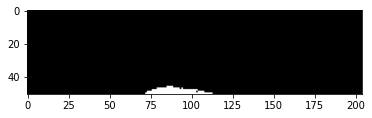

In [ ]:
x,y=im.shape
plt.imshow(kmeans3[y//2-2*y//10:y//2-y//10,x//2-2*x//10:x//2+2*x//10],cmap='gray')
print(np.unique(kmeans3[y//2-3*y//10:y//2-y//10,x//2-2*x//10:x//2+2*x//10]))

- Ce que j'ai fait c'est que j'ai appliqué un clustering k-means avec 6 clusters. 
- Ensuite je récupère le cluster du corpus callosum en selectionnant le cluster de couleur la plus claire au niveau de la zone du CC (recadrage en fonction de la taille de l'image).
- J'applique une décomposition en composantes connexe et cette fois ci je récupère celle du CC en prenant la valeur la plus foncé après la valeur 0
- Ce code s'applique pour toutes les images, on n'a pas besoin de changer le code

Cette technique fonctionne bien pour les 4 images avec une similarité >0.80. C'est beaucoup plus satisfaisant que pour le cas de l'abdomen car les images se ressemblent donc le code peut fonctionner pour toutes les images de la collection sans s'attarder sur des cas spécifiques.

# Skin lesions

In this section, you can try to segment skin lesions (both nevi and melanoma).  You also have manual segmentations. Be careful to the hair...

In [ ]:
skinlesion_path = Working_directory + 'skinlesion'
!ls './skinlesion'

listImages=glob.glob(skinlesion_path + '/*.jpg')
N=len(listImages)
print('There are {} skin lesion images'.format(N))
print(listImages)


IM_000180.jpg		    IM_000833_Segmentation.png
IM_000180_Segmentation.png  ISIC_0000001.jpg
IM_000215.jpg		    ISIC_0000001_Segmentation.png
IM_000215_Segmentation.png  ISIC_0000019.jpg
IM_000407.jpg		    ISIC_0000019_Segmentation.png
IM_000407_Segmentation.png  ISIC_0000042.jpg
IM_000445.jpg		    ISIC_0000042_Segmentation.png
IM_000445_Segmentation.png  ISIC_0000046.jpg
IM_000510.jpg		    ISIC_0000046_Segmentation.png
IM_000510_Segmentation.png  ISIC_0000095.jpg
IM_000613.jpg		    ISIC_0000095_Segmentation.png
IM_000613_Segmentation.png  ISIC_0000146.jpg
IM_000833.jpg		    ISIC_0000146_Segmentation.png
There are 13 skin lesion images
['./skinlesion/IM_000180.jpg', './skinlesion/IM_000445.jpg', './skinlesion/ISIC_0000146.jpg', './skinlesion/IM_000407.jpg', './skinlesion/IM_000510.jpg', './skinlesion/ISIC_0000001.jpg', './skinlesion/IM_000613.jpg', './skinlesion/IM_000215.jpg', './skinlesion/ISIC_0000019.jpg', './skinlesion/IM_000833.jpg', './skinlesion/ISIC_0000095.jpg', './skinlesion/I

Text(0.5, 1.0, 'Image with mask')

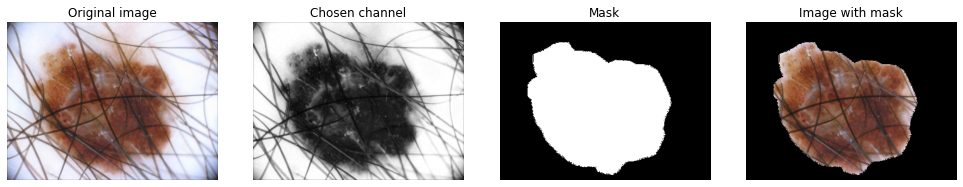

In [ ]:
# Let's load the images, rescale them so that the computations are faster and plot them
# Choose the index of the skin lesion image you want to analyze
indexIm=3
####

filename = listImages[indexIm]
im = imread(filename)
im=im[2:-2,2:-2,:] # remove border (it contains artifacts)
im = np.uint8(rescale(im, 0.25,multichannel=True, anti_aliasing=True)*255)

# To simplify things, let's choose only one channel (gray image)
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
channel=2
##
imG = im[:,:,channel] 

filename_Segmentation = filename[:-4] + '_Segmentation.png'
im_Seg = imread(filename_Segmentation) # Value 0 or 255
im_Seg=im_Seg[2:-2,2:-2] # remove border (it contains artifacts)
im_Seg = rescale(im_Seg, 0.25, anti_aliasing=False, order=0,  preserve_range=True)
maskSL = im_Seg==255 
im_Seg_expand = np.expand_dims(maskSL, axis=2)


fig = plt.figure(figsize=(17, 7))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 4),
                axes_pad = 0.5)
grid[0].imshow(im)
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(imG,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Chosen channel")
grid[2].imshow(maskSL,cmap='gray')
grid[2].axis('off')
grid[2].set_title("Mask")
grid[3].imshow(im_Seg_expand*im)
grid[3].axis('off')
grid[3].set_title("Image with mask")

**Approche : seuillage**

Ici l'image semble simple à ségmenter car si on enlève les poils, elle est dèjà "ségmentée" et un seuillage semblerait suffire par la suite... On teste d'appliquer des fonctions de morphologie puis seuillage par otsu

The dice similarity is  0.9431499796451065


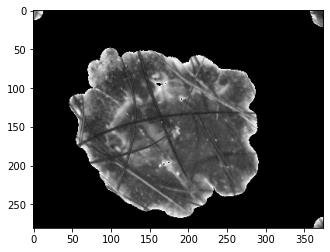

In [ ]:
se = strel('disk',10)
im_dil=morpho.closing(imG,se)#morpho pour enlever les poils
plt.imshow(im_dil,cmap="gray")
threshOtsu = threshold_otsu(im_dil)
binaryOtsu = (im_dil < threshOtsu) 
plt.imshow(binaryOtsu*imG,cmap='gray')
print('The dice similarity is ', 1-dice(binaryOtsu.flatten(),maskSL.flatten()))

Ici sur cette image on a un bon résultat en terme de similarité cependant sur d'autres images, on n'obtient pas un si bon résultat. De plus qualitativement on remarque sur certaines images que les coins sont séléctionnés ce qui n'est pas très satisfaisant même si on a une bonne similarité. Voici le résultat pour une autre image :

The dice similarity is  0.3109505327485196


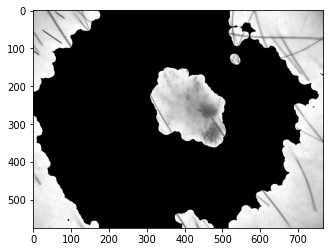

In [ ]:
indexIm=6
####
filename = listImages[indexIm]
im = imread(filename)
im=im[2:-2,2:-2,:] # remove border (it contains artifacts)
im = np.uint8(rescale(im, 0.25,multichannel=True, anti_aliasing=True)*255)
channel=2
imG = im[:,:,channel] 

filename_Segmentation = filename[:-4] + '_Segmentation.png'
im_Seg = imread(filename_Segmentation) # Value 0 or 255
im_Seg=im_Seg[2:-2,2:-2] # remove border (it contains artifacts)
im_Seg = rescale(im_Seg, 0.25, anti_aliasing=False, order=0,  preserve_range=True)
maskSL = im_Seg==255 
im_Seg_expand = np.expand_dims(maskSL, axis=2)



se = strel('disk',10)
im_dil=morpho.closing(imG,se)
threshOtsu = threshold_otsu(im_dil)
binaryOtsu = (im_dil < threshOtsu) 
plt.imshow(binaryOtsu*imG,cmap='gray')
print('The dice similarity is ', 1-dice(binaryOtsu.flatten(),maskSL.flatten()))

Il s'agit du pire résultat car l'image originale est peu contrastée. On peut essayer d'enlever les poils avec un filtre médian plutôt qu'une application morphologique et agire de la même façon par la suite

The dice similarity is  0.32447740765263255


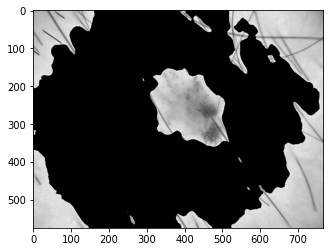

In [ ]:
from scipy import ndimage
medianFilt = ndimage.median_filter(imG, size=20)
threshOtsu = threshold_otsu(medianFilt)
binaryOtsu = (medianFilt < threshOtsu) 
plt.imshow(binaryOtsu*imG,cmap='gray')
print('The dice similarity is ', 1-dice(binaryOtsu.flatten(),maskSL.flatten()))

On obtient globalement le même résultat pour cette image car le problème reste le même, il y a un petit contraste au sein de l'image.
On peut tester une autre méthode : region growing. K-means clustering ne servirait pas à grand chose car avec 2 clusters on obtiendrait un résultat similaire qu'avec Otsu.

The dice similarity is  0.7860683365276584


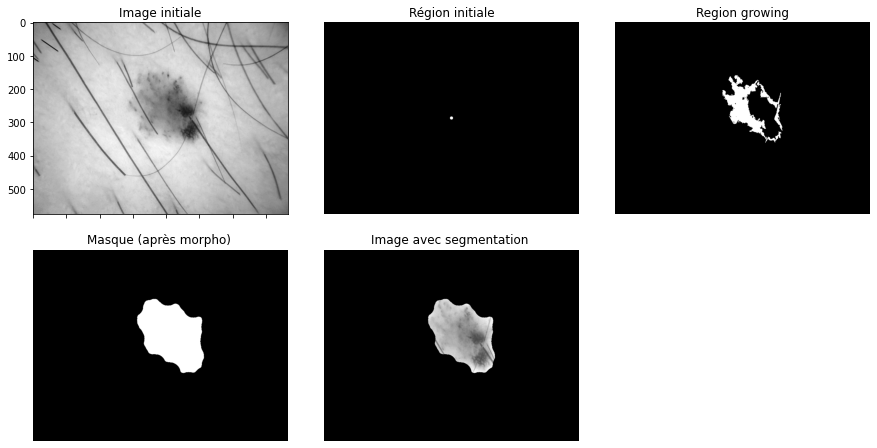

In [ ]:
im=imG
i=imG.shape[0]//2
j=imG.shape[1]//2
#Etape 1 : région growing
seed_pt = np.asarray([i,j])  # initialization with only one point - Try to modify the code to initialize with one region obtained previously
tau = 15
img_out_region_growing,seg_init = segmentation_region_growing(im,seed_pt,tau)

#Etape 2 : morpho
se1 = strel('disk',40)
se2 = strel('disk',10)
im_closing=morpho.closing(img_out_region_growing,se1)
im_dil=morpho.dilation(im_closing,se2)

maskgrowing=im_dil==1
#Affichage
fig = plt.figure(figsize=(15, 10))
grid = AxesGrid(fig, 111,
                nrows_ncols = (2, 3),
                axes_pad = 0.5)
grid[0].imshow(im,cmap='gray')
grid[0].set_title("Image initiale")

grid[1].imshow(seg_init,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Région initiale")

grid[2].imshow(img_out_region_growing,cmap='gray')
grid[2].axis('off')
grid[2].set_title("Region growing")

grid[3].imshow(maskgrowing,cmap='gray')
grid[3].axis('off')
grid[3].set_title("Masque (après morpho) ")
grid[4].imshow(im*maskgrowing, cmap='gray')
grid[4].axis('off')
grid[4].set_title("Image avec segmentation ")

grid[5].axis('off')
print('The dice similarity is ', 1-dice(maskgrowing.flatten(),maskSL.flatten()))

Ici avec cette méthode, (region growing + morpho) on a globalement un resultat proche de 80% de similitude avec le masque original. Même si avec l'autre méthode on avait des résultats à plus de 90% on avait aussi des résultats vers 30%. C'est un compromis. Ces résultats pourraient être mieux avec cette deuxième méthode si on personnalisait les paramètres selon l'image mais j'ai essayé de choisir des paramètres qui sont "corrects" globalement pour toutes les images. Malheuresement si la lesion ou le melanome ne se trouve pas au centre de l'image ces paramètres globaux ne fonctionnent pas.

In [3]:
MRIheart_path = Working_directory + 'MRIheart/'
!ls './MRIheart'

dataMRIheart.mat  segMRIheart.mat


In [4]:
data=loadmat(MRIheart_path + 'dataMRIheart.mat')
data=data['data']
seg=loadmat(MRIheart_path + 'segMRIheart.mat')
seg=seg['seg']

print('MRI volume of the heart composed of', data.shape[2], 'slices along the z axis and', data.shape[3], 
'temporal frames. Each slice is an image ', data.shape[0], ' x ',  data.shape[1])
print('For each slice and at each time frame we have a manual segmentation composed of',seg[4,4].shape[0] , '2D landmarks')

print('Be careful, some slices do not have the left ventricle and the manual segmentation is not simply empty but it contains the value:', seg[0,0] )

MRI volume of the heart composed of 11 slices along the z axis and 20 temporal frames. Each slice is an image  256  x  256
For each slice and at each time frame we have a manual segmentation composed of 65 2D landmarks
Be careful, some slices do not have the left ventricle and the manual segmentation is not simply empty but it contains the value: [[-99999]]


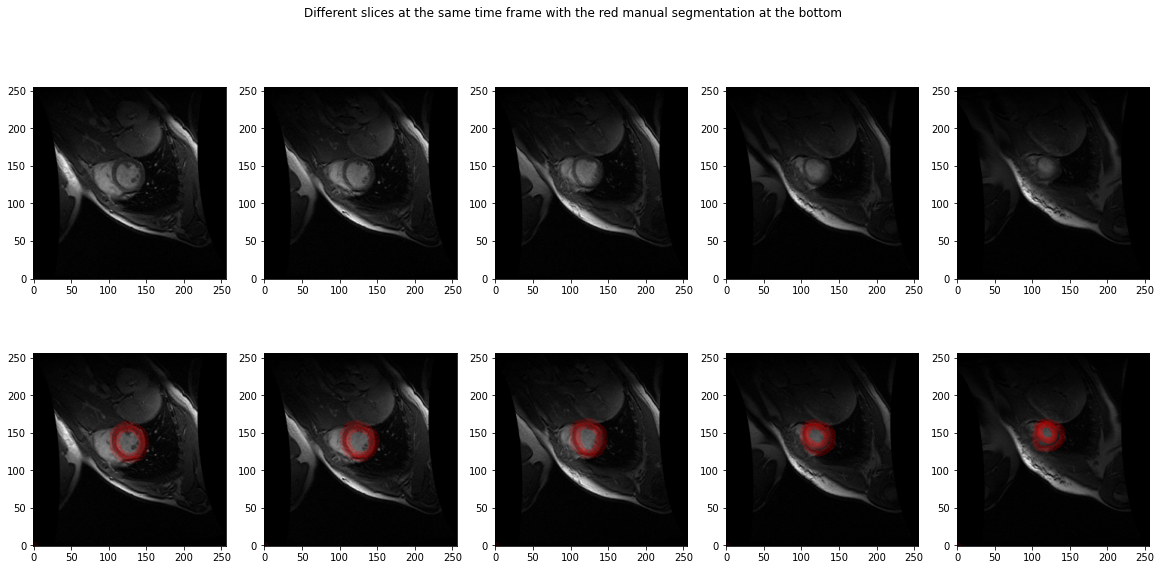

In [5]:
plt.figure(figsize=(20, 9))
plt.suptitle('Different slices at the same time frame with the red manual segmentation at the bottom')
plt.subplot(2, 5, 1)
plt.imshow(data[:,:,4,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 2)
plt.imshow(data[:,:,5,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 3)
plt.imshow(data[:,:,6,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 4)
plt.imshow(data[:,:,7,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 5)
plt.imshow(data[:,:,8,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 6)
plt.imshow(data[:,:,4,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[4,1][:,0], seg[4,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 7)
plt.imshow(data[:,:,5,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[5,1][:,0], seg[5,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 8)
plt.imshow(data[:,:,6,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[6,1][:,0], seg[6,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 9)
plt.imshow(data[:,:,7,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[7,1][:,0], seg[7,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 10)
plt.imshow(data[:,:,8,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[8,1][:,0], seg[8,1][:,1], c='r',alpha=0.1) 

**Methode 1 : avec k-means**

Text(0.5, 1.0, 'Image with segmentation\n ')

<Figure size 1224x504 with 0 Axes>

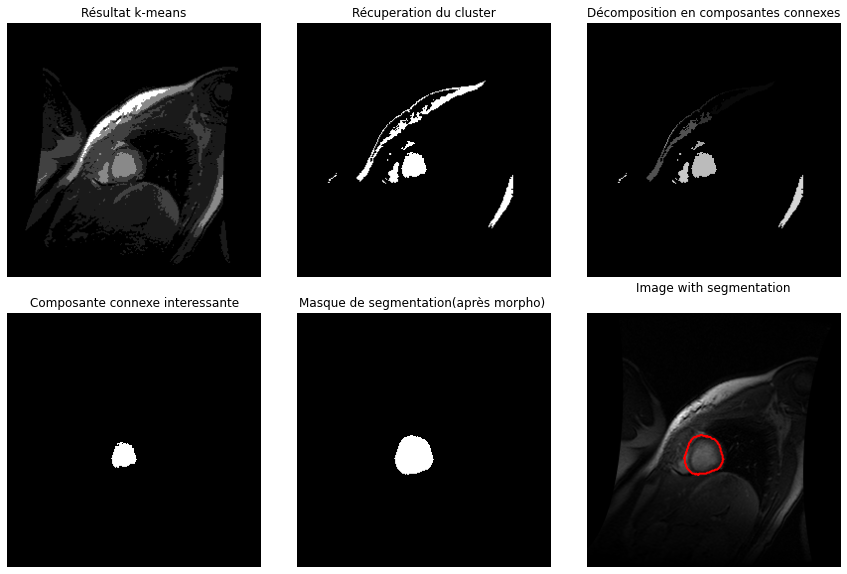

In [8]:
from sklearn.cluster import KMeans
#Etape 1 : K-means
im=data[:,:,7,1]
Ncluster=5

x, y = im.shape
imFloat = np.array(im, dtype=np.float64) / 255 # transform into float for computational reason
kmeans = KMeans(n_clusters=Ncluster, n_jobs=-1) # use K-means algorithm 
kmeans.fit(imFloat.reshape(x*y,1)) # fit to the data reshapds as a 1D vector

cluster_centers = kmeans.cluster_centers_ # estimated centers
cluster_labels = kmeans.labels_ # estimated labels for each pixel

kmeansSeg = cluster_centers[cluster_labels].reshape(x, y) # reshaped as the original image
cluster_centers[:,0].sort()

#Etape 2 : Decomposition en composantes connexes

kmeans2= kmeansSeg==cluster_centers[3]
kmeans3 = ndi.label(kmeans2)[0]
fig = plt.figure(figsize=(17, 7))

#Etape 3 : Morpho
kmeans4 = (kmeans3==kmeans3[145,125])
se = strel('disk',7)
im_dil=morpho.dilation(kmeans4,se)
im_closing=morpho.closing(im_dil,se)

maskheart=im_closing==1
contourMask = find_contours(maskheart, 0.5)

# Affichage 
fig = plt.figure(figsize=(15, 10))
grid = AxesGrid(fig, 111,
                nrows_ncols = (2, 3),
                axes_pad = 0.5)
grid[0].imshow(kmeansSeg, cmap='gray')
grid[0].axis('off')
grid[0].set_title("Résultat k-means")

grid[1].imshow(kmeans2, cmap='gray')
grid[1].axis('off')
grid[1].set_title("Récuperation du cluster")

grid[2].imshow(kmeans3, cmap='gray')
grid[2].axis('off')
grid[2].set_title("Décomposition en composantes connexes")

grid[3].imshow(kmeans4, cmap='gray')
grid[3].axis('off')
grid[3].set_title("Composante connexe interessante")

grid[4].imshow(maskheart,cmap='gray')
grid[4].axis('off')
grid[4].set_title("Masque de segmentation(après morpho) ")

grid[5].imshow(im, cmap='gray')
for contour in contourMask:
  grid[5].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[5].axis('off')
grid[5].set_title("Image with segmentation\n ")

Cette méthode consiste à appliquer un clustering avec 5 clusters, récuperer le cluster puis la composante connexe où se trouve le ventricule. Finalement en appliquant une dilatation puis une fermeture pour remplir et elargir la zone récupérée on obtient le masque. De façon qualitative cette méthode fonctionne correctement sans changer le code  pour toutes les images sauf pour data[:,:,5,1]. Evidemment elle n'est pas parfaite, elle arrive a situer globalement ou se trouve le ventricule mais n'arrive pas à faire son contour parfait. Cette méthode de plus utilise 2 grandes méthodes (clustering + décompositionen composante connexe). Essayons avec une autre méthode

**Methode 2 avec region growing**

(-0.5, 255.5, 255.5, -0.5)

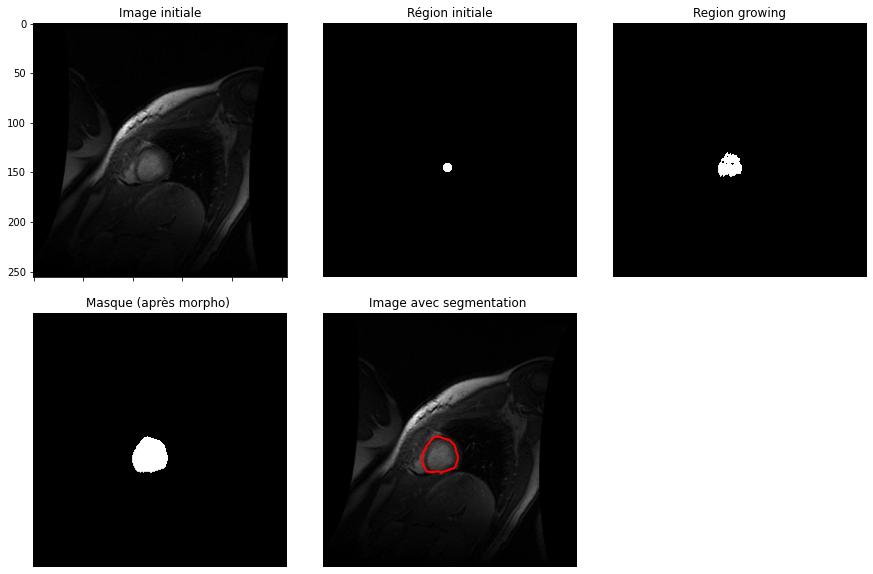

In [13]:
im=data[:,:,7,1]

#Etape 1 : région growing
seed_pt = np.asarray([145,125])  # initialization with only one point - Try to modify the code to initialize with one region obtained previously
tau = 70
img_out_region_growing,seg_init = segmentation_region_growing(im,seed_pt,tau)

#Etape 2 : morpho
se = strel('disk',6)
im_dil=morpho.dilation(img_out_region_growing,se)
im_closing=morpho.closing(im_dil,se)

maskheart=im_closing==1
contourMask = find_contours(maskheart, 0.5)
#Affichage
fig = plt.figure(figsize=(15, 10))
grid = AxesGrid(fig, 111,
                nrows_ncols = (2, 3),
                axes_pad = 0.5)
grid[0].imshow(im,cmap='gray')
grid[0].set_title("Image initiale")

grid[1].imshow(seg_init,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Région initiale")

grid[2].imshow(img_out_region_growing,cmap='gray')
grid[2].axis('off')
grid[2].set_title("Region growing")

grid[3].imshow(maskheart,cmap='gray')
grid[3].axis('off')
grid[3].set_title("Masque (après morpho) ")
grid[4].imshow(im, cmap='gray')
for contour in contourMask:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[4].axis('off')
grid[4].set_title("Image avec segmentation ")

grid[5].axis('off')

De façon qualitative cette méthode donne un résultat similaire à la précedente. On retrouve le même problème pour l'image data[:,:5,1]. Même en changeant les paramètres on obtient avec cette image un masque trop grand qui sélectionne une partie qui n'est pas le ventricule. Avec cette méthode on n'a pas besoin de faire une décomposition en composantes connexes et sans changer le code ici aussi on obtient des bons résultats pour chaque image globalement.


Avec ces deux méthodes cela fonctionne bien car la collection d'image se ressemble, en terme de taille, de décalage (décalage négligeable), et d'echelle. C'est pour cela qu'on n'a pas besion de changer les paramètre d'une image à une autre.


_______________________________________________________________________
# **Useful functions**

In [7]:
def strel(forme,taille,angle=45):
    """renvoie un element structurant de forme  
     'diamond'  boule de la norme 1 fermee de rayon taille
     'disk'     boule de la norme 2 fermee de rayon taille
     'square'   carre de cote taille (il vaut mieux utiliser taille=impair)
     'line'     segment de langueur taille et d'orientation angle (entre 0 et 180 en degres)
      (Cette fonction n'est pas standard dans python)
    """

    if forme == 'diamond':
        return morpho.selem.diamond(taille)
    if forme == 'disk':
        return morpho.selem.disk(taille)
    if forme == 'square':
        return morpho.selem.square(taille)
    if forme == 'line':
        angle=int(-np.round(angle))
        angle=angle%180
        angle=np.float32(angle)/180.0*np.pi
        x=int(np.round(np.cos(angle)*taille))
        y=int(np.round(np.sin(angle)*taille))
        if x**2+y**2 == 0:
            if abs(np.cos(angle))>abs(np.sin(angle)):
                x=int(np.sign(np.cos(angle)))
                y=0
            else:
                y=int(np.sign(np.sin(angle)))
                x=0
        rr,cc=morpho.selem.draw.line(0,0,y,x)
        rr=rr-rr.min()
        cc=cc-cc.min()
        img=np.zeros((rr.max()+1,cc.max()+1) )
        img[rr,cc]=1
        return img
    raise RuntimeError('Erreur dans fonction strel: forme incomprise')



To quantitavely compare two segmentations, we can use the [Dice score](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient). Remember that you should also visually compare your segmentation and the reference one, when available. 

In [ ]:
# Evaluation quantitative par indice de Dice (vous pouvez aussi utiliser la fonctionne dice de scipy)
def Dice(segm,segm_ref):
    if segm.shape != segm_ref.shape:
        raise ValueError("Les deux images doivent avoir la meme taille.")
    segm = np.asarray(segm).astype(np.bool)
    segm_ref = np.asarray(segm_ref).astype(np.bool)
    intersection = np.logical_and(segm, segm_ref)
    dice = 2.0 * intersection.sum() / (segm.sum()+segm_ref.sum())
    return dice

# Comparaison visuelle (segm peut être un masque de segmentation ou son contour)
# vous pouvez aussi utiliser la fonctionen find_contours
def ComparVisu(image,segm):
    return np.maximum(image,segm)
def Contour(segm):
    se=morpho.selem.disk(1)
    contour=morpho.dilation(segm,se)-segm
    # ou dilatation - erosion pour avoir un contour de 2 pixels d'épaisseur (plus visible)
    return contour

## 1. Threshold segmentation
- First, compare the histograms of the images of the same modality. Do the histograms have the same range of values across modalities ? Could you use the same threshold (manually found) across modalities to correctly retrieve the segmentation ? Comment the results.


In [ ]:
# Histogram
im=imG
#ax = plt.hist(im.ravel(), bins = 256)
plt.show()

# manual thresholding
thresh = 100
binary = (im > thresh) *255
fig = plt.figure(figsize=(17, 7))
#plt.imshow(binary, cmap="gray", vmin=0, vmax=255)


<Figure size 1224x504 with 0 Axes>

###Otsu's algorithm

Otsu's method looks for a threshold to split a gray-level image into two separate regions, based on their grey-level values. Since the maximum number of grey-levels is finite (and small, 256), we can use an exhaustive search.

The grey-level threshold is the one that minimises the intra-class intensity variance, defined as a weighted sum of the variances of the two regions :

$argmin_{\tau}  \omega_0(\tau)\sigma_0^2(\tau) + \omega_1(\tau)\sigma_1^2(t)$

where

- $\sigma_0^2(\tau)$ and $\sigma_1^2(\tau)$ are the intensity variances of the pixels in the first and second regions
- $\omega_0(\tau)$ and $\omega_1(\tau)$ are the weights of the first and second regions 

Given the histogram of the image with $L$ bins where each bin $i$ has $p(i)$ pixels, we define the weights $\omega_0(\tau)$ and $\omega_1(\tau)$ as:

- $\omega_0(\tau) = \sum_{i=0}^{\tau -1} p(i)$
- $\omega_1(\tau) = \sum_{i = \tau}^{L-1} p(i)$


Use the function ``threshold_otsu`` across different modalities. Comment the results. Does the algorithm find the same threshold as the one you previously found manually?

In [ ]:
# seuillage d'Otsu

im=imG
threshOtsu = threshold_otsu(im)
print('Otsu threshold is ', threshOtsu)
binaryOtsu = (im > threshOtsu) *255
fig = plt.figure(figsize=(17, 7))
#plt.imshow(binaryOtsu, cmap="gray", vmin=0, vmax=255)

Otsu threshold is  74


<Figure size 1224x504 with 0 Axes>

### K-means

Now, let's try to use K-means to directly segment the image. We will use the scikit-learn implementation.

Try to change the number of clusters, can you correctly segment all modalities ? Would you choose the same number of clusters for all modalities ? Once found the clusters, how would you choose the one to use as segmentation mask ?
Comment the results.

In [ ]:
#k-means
from sklearn.cluster import KMeans

im=imG
Ncluster=6

x, y = im.shape
imFloat = np.array(im, dtype=np.float64) / 255 # transform into float for computational reason
kmeans = KMeans(n_clusters=Ncluster, n_jobs=-1) # use K-means algorithm 
kmeans.fit(imFloat.reshape(x*y,1)) # fit to the data reshapds as a 1D vector

cluster_centers = kmeans.cluster_centers_ # estimated centers
cluster_labels = kmeans.labels_ # estimated labels for each pixel

kmeansSeg = cluster_centers[cluster_labels].reshape(x, y) # reshaped as the original image
fig = plt.figure(figsize=(17, 7))
#plt.imshow(kmeansSeg, cmap="gray", vmin=0, vmax=np.max(kmeansSeg))

<Figure size 1224x504 with 0 Axes>

## 2. Region growing

The region growing algorithm is quite simple : we start with a small region, and add pixels progressively to the region, according to a criterion. We choose the following criterion :

- A pixel $p$ is added to the region if the absolute difference between the pixel value and the region's average value is less than a threshold value (which you must set).

First, we can create a function called ``initialize_segmentation`` which initialises the segmentation with a small circular region centred on a given seed point (the seed point is an input). For this, the following function :

- scipy.ndimage.morphology.distance_transform_edt

can be useful.
The initialization can be done using a single point or using one of the previous techniques which can also be improved using pre- or post processing techniques. Would you use the same strategy (ie algorithm) for all medical images ? Propose a strategy for each medical image.

Here you can find an example of algorithm. Please modify it accordingly to each modality.


In [10]:
from scipy.ndimage.morphology import distance_transform_edt

def initialize_segmentation(seed_pt,img_shape):
    seg_init = np.zeros(img_shape).astype(float)
    seg_init[ seed_pt[0], seed_pt[1]] = 1
    dist = distance_transform_edt(np.abs(1-seg_init))

    # initialise the seeded region with a certain radius
    size_radius = 5
    seg_init = dist < size_radius
    return seg_init


In [12]:
def segmentation_region_growing(img,seed_pt,tau):

    # define the neighbourhood (for instance 4-connected pixels)
    se=morpho.selem.diamond(1)

    seg_init = initialize_segmentation(seed_pt,img.shape)
    seg_n_plus_1 = seg_init
    seg_n = np.zeros(seg_n_plus_1.shape)

    # loop while the region can still keep growing
    while( np.abs(seg_n_plus_1 != seg_n).sum() != 0):
        seg_n = seg_n_plus_1
        seg_n_plus_1 = morpho.dilation(seg_n, se).astype(seg_n.dtype)
        # calculate average value
        avg = np.sum( img[seg_n>0] ) / ( float(seg_n.sum()))
        seg_n_plus_1 = np.logical_and( seg_n_plus_1 , np.abs( img-avg ) < tau)
        # do not lose previous points of the segmentation
        seg_n_plus_1 = np.logical_or( seg_n_plus_1 , seg_n)

    return seg_n,seg_init


seed_pt = np.asarray([125,125])  # initialization with only one point - Try to modify the code to initialize with one region obtained previously
tau = 20
img_out_region_growing,seg_init = segmentation_region_growing(im,seed_pt,tau)

##fig = plt.figure(figsize=(12, 12))
##grid = AxesGrid(fig, 111,
#                nrows_ncols = (1, 3),
#                axes_pad = 0.5)
##grid[0].imshow(im,cmap='gray')
##grid[0].axis('off')
##grid[0].set_title("image")
##grid[1].imshow(seg_init,cmap='gray')
##grid[1].axis('off')
##grid[1].set_title("Initial region")
##grid[2].imshow(img_out_region_growing,cmap='gray')
##grid[2].axis('off')
##grid[2].set_title("Region growing segmentation")


## 3. Watershed segmentation

The initialization can be done using a single point or using one of the previous techniques which can also be improved using pre- or post processing techniques. Would you use the same strategy (ie algorithm) for all medical images ? Propose a strategy for each medical image.

Here you can find an example of algorithm. Please modify it accordingly to each modality.

In [ ]:
#im=im0
#gradient morphologique de l'image initiale
se=morpho.selem.disk(1)
grad=morpho.dilation(im,se)-morpho.erosion(im,se)
fig = plt.figure(figsize=(17, 7))
#plt.imshow(grad, cmap="gray")

# Exemple d'initialization (qui doit être modifié...)
temp=np.zeros((binary.shape[0],binary.shape[1]),dtype=np.uint8)
for i in range(150,350):
    for j in range(150,350):
        temp[i,j]=255
init=np.minimum(binary,temp)

#plt.imshow(init, cmap="gray", vmin=0, vmax=255)


#ajout d'un marqueur sur le bord de l'image
for i in range(init.shape[0]):
    init[i,0]=255
    init[i,init.shape[1]-1]=255
for j in range(init.shape[1]):
    init[0,j]=255
    init[init.shape[0]-1,j]=255
#fig = plt.figure(figsize=(17, 7))
#plt.imshow(init, cmap="gray", vmin=0, vmax=255)

markers = ndi.label(init)[0]
#fig = plt.figure(figsize=(17, 7))
#plt.imshow(markers)

labels = morpho.watershed(grad, markers,watershed_line=True)
#fig = plt.figure(figsize=(17, 7))
#plt.imshow(labels)

# visualiation du resultat
segm=labels.copy()
for i in range(segm.shape[0]):
    for j in range(segm.shape[1]):
        if segm[i,j] == 0: 
            segm[i,j]=255
        else:
            segm[i,j]=0
#fig = plt.figure(figsize=(17, 7))
#plt.imshow(segm, cmap="gray", vmin=0, vmax=255)

<Figure size 1224x504 with 0 Axes>

6. Segmentation d'une séquence - Sur les images d'IRM cardiaque, proposer une méthode de segmentation qui utilise le résultat à un instant pour initialiser la segmentation à l'instant suivant (par exemple sur la coupe z=2 ou z=3). Illustrer et discuter. Est-ce pertinent d'utiliser la même approche pour guider la segmentation d'une coupe par celle de la coupe précédente ?

Je ne trouve pas pertinant de faire cela, car il est plus difficile d'adapter un masque déjà exsitant plutot que d'un construire un adapté à l'image

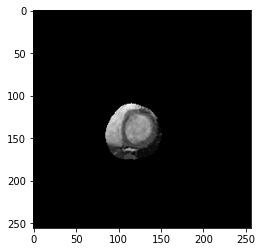

In [42]:
im2=data[:,:,2,1]
mask=maskheart #le masque de l'image 7

#Dilatation pour elargir la zone 
newmask=morpho.dilation(mask,strel('disk',15))
plt.imshow(im2*newmask,cmap="gray")

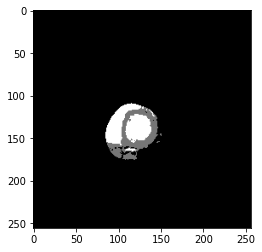

In [43]:
Ncluster=3

x, y = (newmask*im2).shape
imFloat = np.array(newmask*im2, dtype=np.float64) / 255 # transform into float for computational reason
kmeans = KMeans(n_clusters=Ncluster, n_jobs=-1) # use K-means algorithm 
kmeans.fit(imFloat.reshape(x*y,1)) # fit to the data reshapds as a 1D vector

cluster_centers = kmeans.cluster_centers_ # estimated centers
cluster_labels = kmeans.labels_ # estimated labels for each pixel

kmeansSeg = cluster_centers[cluster_labels].reshape(x, y) # reshaped as the original image
cluster_centers[:,0].sort()
plt.imshow(kmeansSeg,cmap="gray")

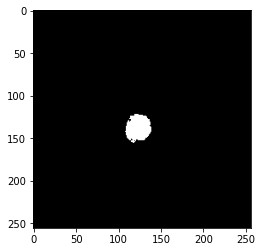

In [44]:
kmeans2= kmeansSeg==cluster_centers[2]
kmeans3 =ndi.label(kmeans2)[0]
kmeans4=kmeans3==np.unique(kmeans3)[-2]
plt.imshow(kmeans4,cmap='gray')

Text(0.5, 1.0, 'Image avec segmentation ')

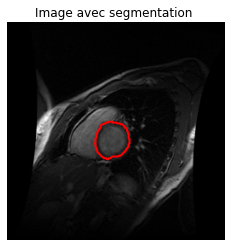

In [45]:
newmask_heart= morpho.dilation(kmeans4,strel("disk",5))
contourMask = find_contours(newmask_heart, 0.5)
plt.imshow(im2, cmap='gray')
for contour in contourMask:
  plt.plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
plt.axis('off')
plt.title("Image avec segmentation ")


Finalement ce n'est pas très utile mis à part le fait qu'on fait un clustering k-means avec moins de cluster